# Stack Overflow Tag Prediction

### Problem Statement 
Predict as many tags as possible with high precision and recall based on the content that is there in the questions posted on Stackoverflow. 
Incorrect tags could impact customer experience on StackOverflow. There is no strict latency constraints.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from sqlalchemy import create_engine 
import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import joblib
import dill

In [2]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [3]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the database:",end=" ")
    tables = table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! Cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS Questions (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Questions.db", sql_create_table)

Tables in the database: Questions


In [4]:
start = datetime.now()
read_db = 'Train.db'

if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags FROM no_dup_train ORDER BY RANDOM() LIMIT 200001;")

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:25:11.439066


In [5]:
write_db = 'Questions.db'
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM Questions WHERE 1")
            print("Cleared all the rows")

Tables in the database: Questions
Cleared all the rows


In [8]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_processed = 0
for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    
    words_pre = len(question)+len(title)
    len_pre+=words_pre
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    #Adding title three time to the data to increase its weight
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question except for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    words_post=len(question)
    len_post+=words_post
    
    tup = (question,code,tags,words_pre,words_post,is_code)
    questions_processed += 1
    writer.execute("INSERT INTO Questions(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_processed%10000==0):
        print("Number of questions completed=",questions_processed)

avg_len_pre=(len_pre*1.0)/questions_processed
avg_len_post=(len_post*1.0)/questions_processed

print( "Avg length of questions(Title+Body) before processing: %d"%avg_len_pre)
print( "Avg length of questions((Title*3)+Body) after processing: %d"%avg_len_post)
print ("Percentage of questions containing code: %d"%((questions_with_code*100.0)/questions_processed))

print("Time taken to run this cell :", datetime.now() - start)

Number of questions completed= 10000
Number of questions completed= 20000
Number of questions completed= 30000
Number of questions completed= 40000
Number of questions completed= 50000
Number of questions completed= 60000
Number of questions completed= 70000
Number of questions completed= 80000
Number of questions completed= 90000
Number of questions completed= 100000
Number of questions completed= 110000
Number of questions completed= 120000
Number of questions completed= 130000
Number of questions completed= 140000
Number of questions completed= 150000
Number of questions completed= 160000
Number of questions completed= 170000
Number of questions completed= 180000
Number of questions completed= 190000
Avg length of questions(Title+Body) before processing: 1172
Avg length of questions((Title*3)+Body) after processing: 408
Percentage of questions containing code: 57
Time taken to run this cell : 0:09:22.095984


In [9]:
#Close the connections to avoid ending up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [4]:
write_db = 'Questions.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question,tags From Questions LIMIT 10")
        preprocessed_data = pd.read_sql_query("""SELECT question, tags FROM Questions""", conn_r)
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('rest rout two user see differ page perform function rest rout two user see differ page perform function rest rout two user see differ page perform function report control two type user compani custom see dramat differ page go view main report page i.e would usual call index page differ respect user main window report best way organ rest way far someth like index compani custindex custom better way note page coupl simpl differ otherwis simpl statement base user type would suffic', 'ruby-on-rails ruby-on-rails-3 rest')
----------------------------------------------------------------------------------------------------
('launch applic instal port freebsd launch applic instal port freebsd launch applic instal port freebsd instal nano freebsd port tri launch immedi instal complet fail complain command found log log back work rememb year back first start play freebsd someon gave command issu instal port dont logout logback tri search onlin dont know search', 'f

In [5]:
preprocessed_data.head(5)

,question,tags
0,ignor creat tabl exist postgresql databas ecli...,postgresql jpa persistence eclipselink postgre...
1,rest rout two user see differ page perform fun...,ruby-on-rails ruby-on-rails-3 rest
2,launch applic instal port freebsd launch appli...,freebsd ports
3,fblogindialog auto ask basic permiss didlogin ...,iphone facebook facebook-connect
4,android listview select problem android listvi...,android


In [6]:
print("Number of data points in sample :", preprocessed_data.shape[0])
print("Number of dimensions :", preprocessed_data.shape[1])

Number of data points in sample : 199998
Number of dimensions : 2


In [10]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true', max_features=500)
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])
dill.dump(vectorizer, open('label_vectorizer.pkl','wb')) 

In [11]:
print(multilabel_y.shape)

(199998, 500)


In [12]:
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.htaccess', '.net', '.net-4.0', '2010', '3d', 'abstract-algebra', 'actionscript', 'actionscript-3', 'active-directory', 'activerecord']


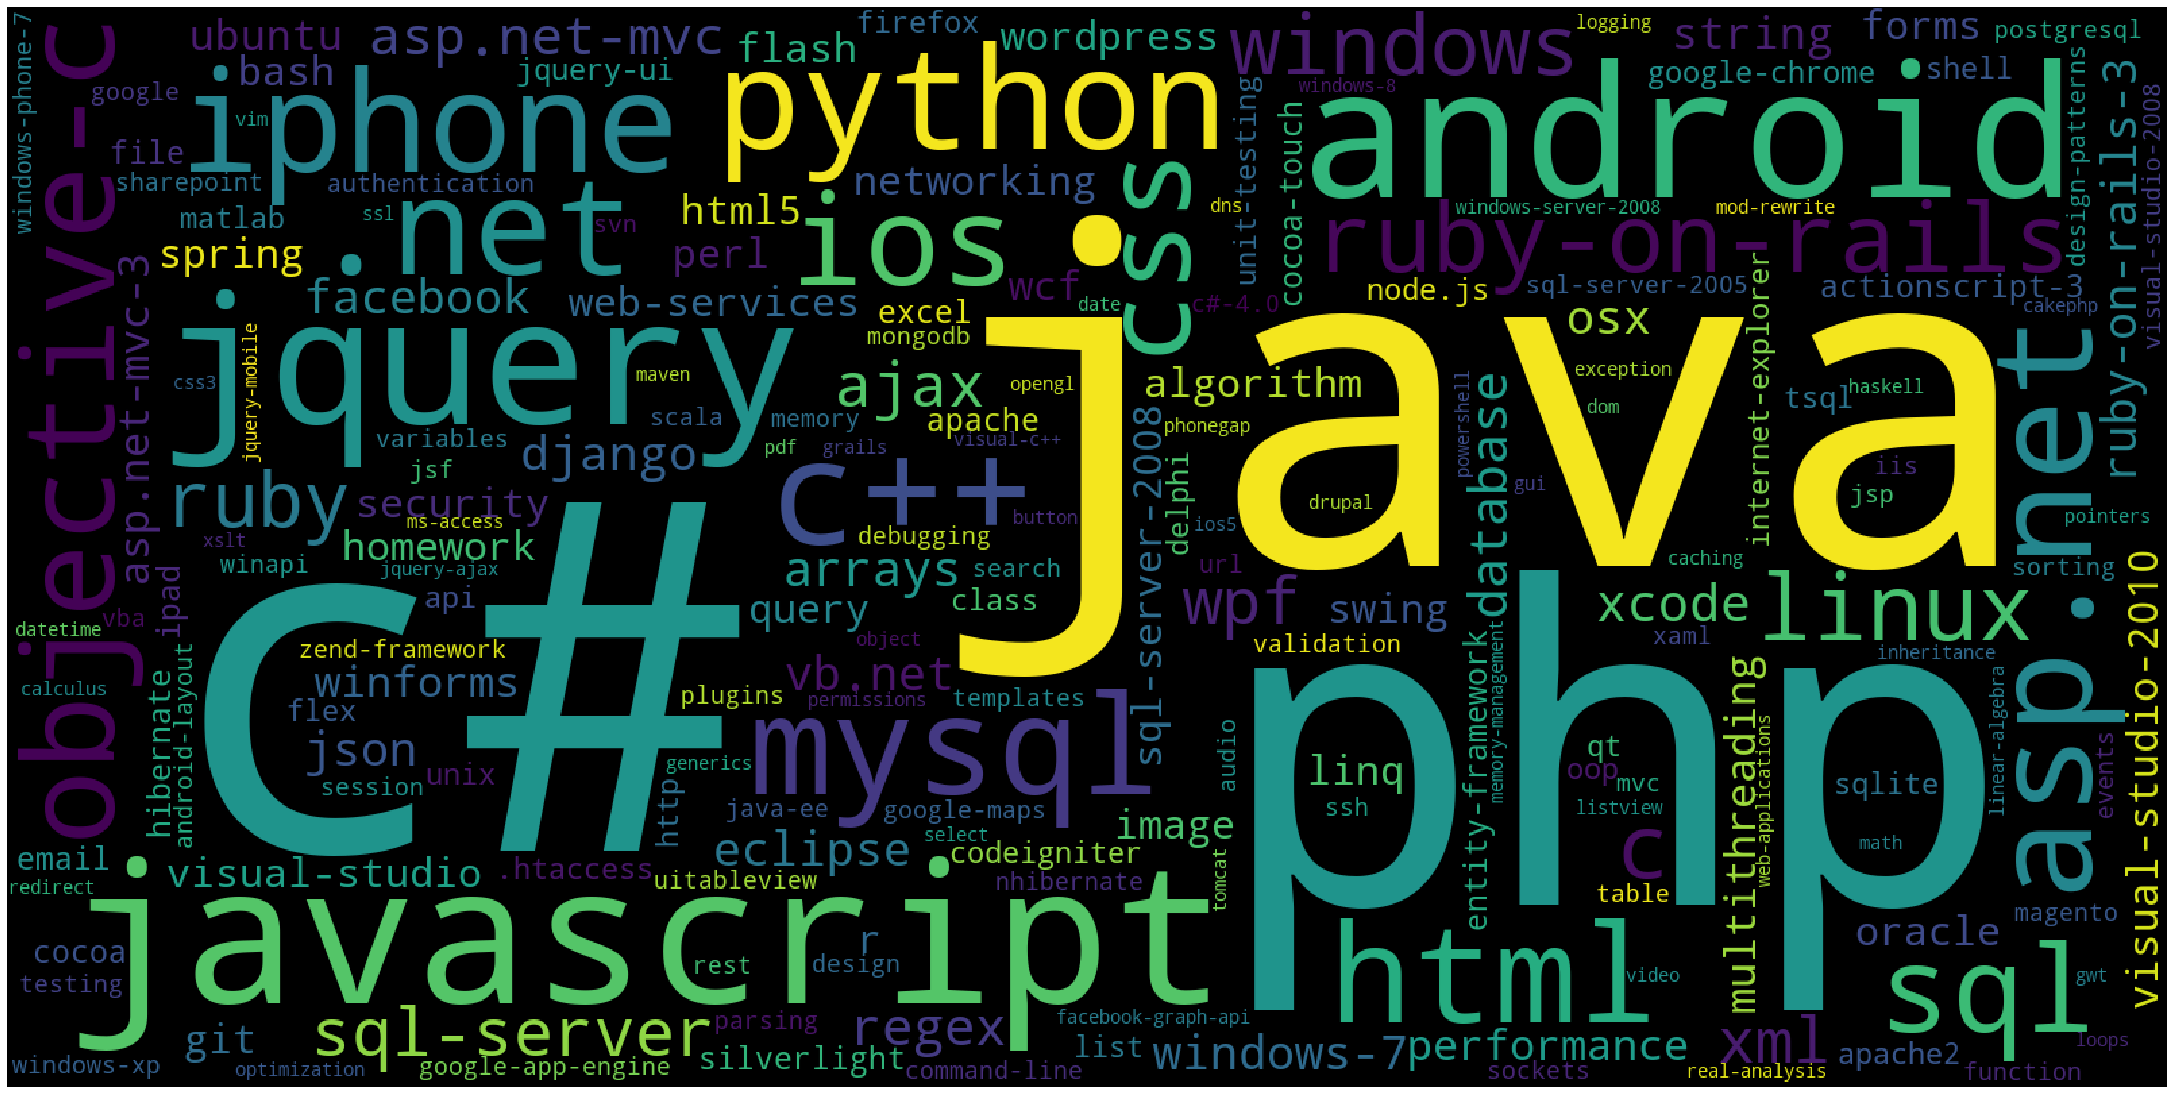

Time taken to run this cell : 0:00:07.046242


In [13]:
from wordcloud import WordCloud
# Ploting word cloud
start = datetime.now()

freqs = multilabel_y.sum(axis=0).A1
result = dict(zip(tags, freqs))
tup = dict(result.items())

#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='black', width=1600, height=800).generate_from_frequencies(tup)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

print("Time taken to run this cell :", datetime.now() - start)

In [11]:
def tags_to_choose(n):
    t = multilabel_tags_all.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_tags_all[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [12]:
questions_explained = []
vect = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_tags_all = vect.fit_transform(preprocessed_data['tags'])
print(multilabel_tags_all.shape)
total_tags=multilabel_tags_all.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

(199998, 23754)


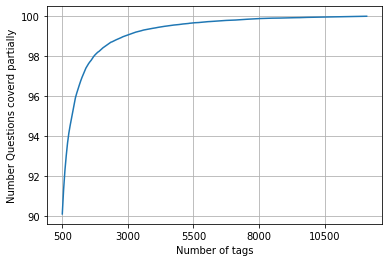

With  500 tags we are covering  90.097 % of questions


In [21]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("With",500,"tags we are covering ",questions_explained[0],"% of questions")

In [14]:
x_train=preprocessed_data.head(160000)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 160000)

y_train = multilabel_y[0:160000,:]
y_test = multilabel_y[160000:preprocessed_data.shape[0],:]

In [15]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
dill.dump(vectorizer, open('ques_vectorizer.pkl','wb'))         

x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:02:45.128167


In [16]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (160000, 87594) Y : (160000, 500)
Dimensions of test data X: (39998, 87594) Y: (39998, 500)


In [17]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2433621681084054
Hamming loss  0.002766488324416221
Micro-average quality numbers
Precision: 0.7386, Recall: 0.3609, F1-measure: 0.4849
Macro-average quality numbers
Precision: 0.5649, Recall: 0.2757, F1-measure: 0.3546
Time taken to run this cell : 0:06:57.416848


In [18]:
joblib.dump(classifier, 'LR_model.pkl') 

['LR_model.pkl']

In [19]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l2'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.26028801440072
Hamming loss  0.00264293214660733
Micro-average quality numbers
Precision: 0.8179, Recall: 0.3440, F1-measure: 0.4843
Macro-average quality numbers
Precision: 0.5079, Recall: 0.2493, F1-measure: 0.3081
Time taken to run this cell : 0:02:45.333890


In [20]:
joblib.dump(classifier, 'SVM_model.pkl') 

['SVM_model.pkl']